In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm


import pandas as pd
import numpy as np
import scipy

In [3]:
from strategies.strategy_ichimokucloud import StrategyIchimokuCloud

In [4]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = '*'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

ES_BullishCollarBW
ES_BearishCollarBW
ES_CallSpread
ES_PutSpread
ES_ContFut
ZS_BullishCollarBW
ZS_BearishCollarBW
ZS_CallSpread
ZS_PutSpread
ZS_ContFut
CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
ZW_BullishCollarBW
ZW_BearishCollarBW
ZW_CallSpread
ZW_PutSpread
ZW_ContFut
NG_BullishCollarBW
NG_BearishCollarBW
NG_CallSpread
NG_PutSpread
NG_ContFut
ZN_BullishCollarBW
ZN_BearishCollarBW
ZN_CallSpread
ZN_PutSpread
ZN_ContFut


## Script settings

In [470]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': StrategyIchimokuCloud,
        'exo_name': 'CL_CallSpread',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [1]),
                        OptParam('conversion_line_period', 9, 5, 25, 20),
                        OptParam('base_line_period', 26, 26, 26, 13),
                        OptParam('leading_spans_lookahead_period', 26, 26, 26, 13),
                        OptParam('leading_span_b_period', 52, 26, 26, 2),
                        #OptParamArray('RulesIndex', np.arange(14)),
                        #OptParamArray('RulesIndex', [7]),
                        OptParam('MedianPeriod', 5, 13, 26, 13)
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [471]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

In [472]:
#smgr = Swarm.load(strategy_context=STRATEGY_CONTEXT, directory='./swarms/')
#print('Loading: '+smgr.get_swarm_name())

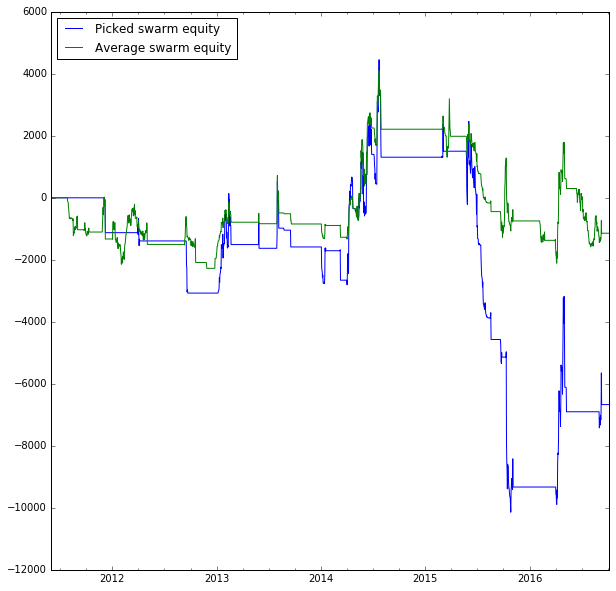

In [473]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

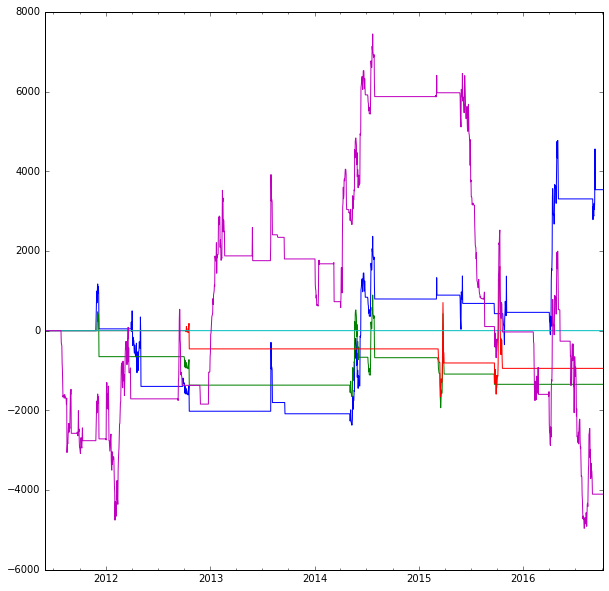

In [474]:
smgr.raw_swarm.plot(legend=False)

In [475]:
#
# To export swarms above to .csv, uncomment this
#

#swarm_df = smgr.swarm
#swarm_df.to_csv('./temp_swarms/ichi_swarm.csv')

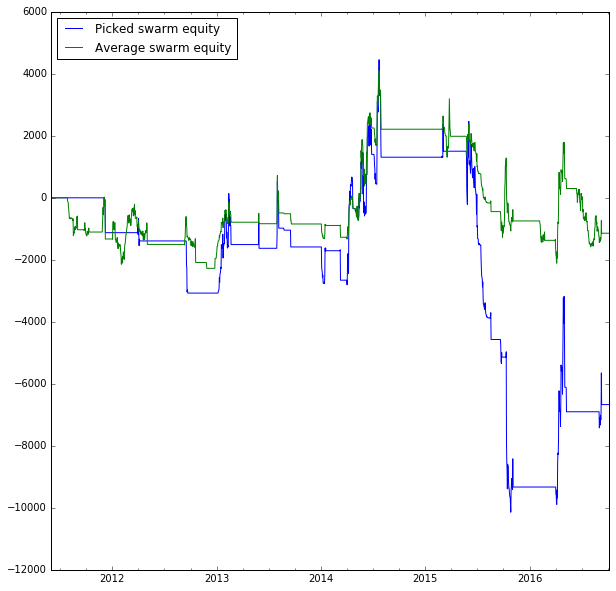

In [476]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

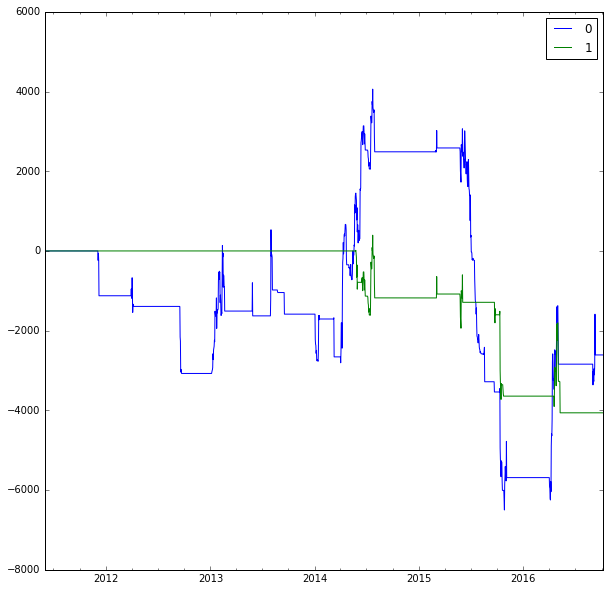

In [477]:
smgr.picked_swarm.plot()

# Swarm exposure

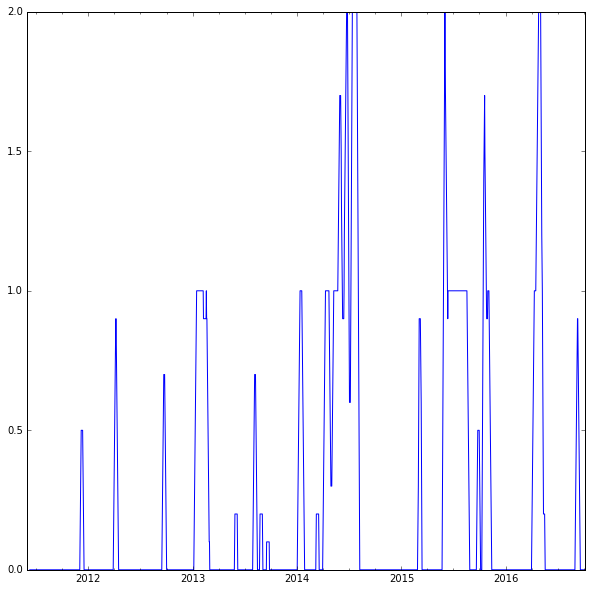

In [478]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [479]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [480]:
smgr.strategy.exoinfo.exo_info

{'margin': 0,
 'name': 'CL_CallSpread',
 'pcf': [],
 'pcfqty': [],
 'underlying': ''}

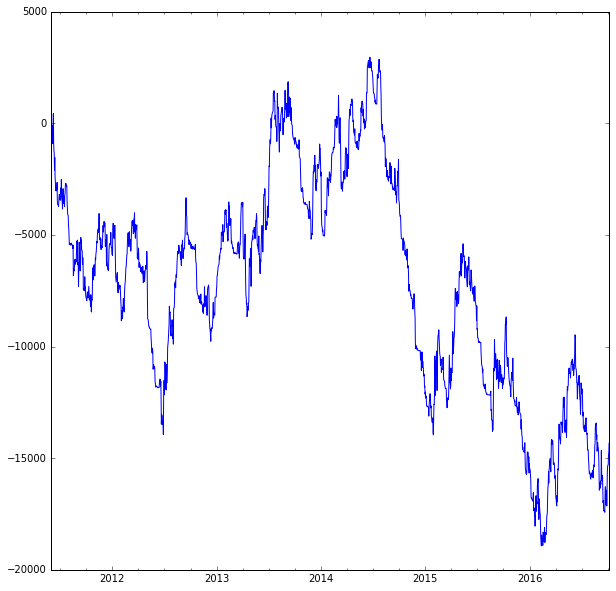

In [481]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

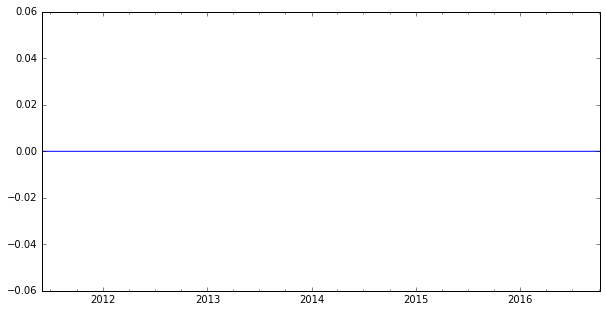

In [482]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

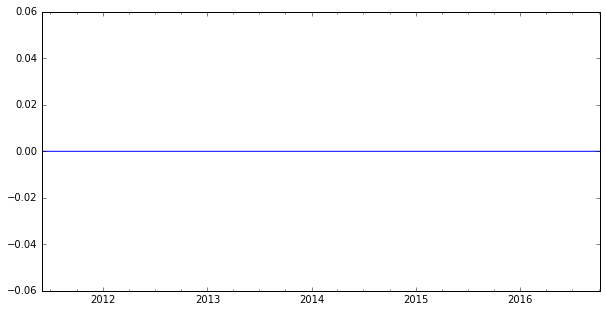

In [483]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [484]:
smgr.save('./swarms/')